In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter
from functools import reduce

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

pandas 1.5.2
numpy 1.23.5
matplotlib 3.7.2
scipy 1.10.0
seaborn 0.12.2


In [2]:
##Write some informations on your assay that we will use later to have titles and save files + load files
name = "C_albicans_H468T_hetero_homozygous"
time = 24 #Needs to be a number, don't add the H after, ex : 24, 32, 36, 48, 72
date = "2024-06-12"

antifungal = "Control and Fluconazole"

OD_file = 'gc_2024-06-12.xlsx'


#importation of excel plan of the concentrations and the strains in your plate (and the wells)
plan = 'plan_c_albicans_gc_2024-06-12.xlsx'  ##change the name of the file

concentrations = pd.read_excel(plan, sheet_name='Sheet1', header=0, index_col=0) #sheet 1 = concentrations plan
strains = pd.read_excel(plan, sheet_name='Sheet2', header=0, index_col=0) #sheet 2 = strains plan
well = pd.read_excel(plan, sheet_name='Sheet3', header=0, index_col=0) #sheet 3 = well names plan
tps = pd.read_excel(plan, sheet_name='Sheet4', header=0, index_col=0) #sheet 4= antifungals plan


In [3]:
#importation of excel output from the TECAN 
source_df = pd.read_excel(OD_file, header=0, index_col=0)
source_df = source_df.transpose()
source_df.head()

Time,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
C5,0.178,0.183,0.181,0.180,0.180,0.180,0.181,0.183,0.184,0.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1,1.127,1.177,1.135,1.134,1.140,1.148,1.153,1.160,1.163,1.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,1.299,1.298,1.276,1.264,1.260,1.264,1.268,1.270,1.272,1.276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,0.282,0.345,0.291,0.288,0.297,0.301,0.319,0.333,0.350,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,0.423,0.517,0.449,0.420,0.434,0.457,0.482,0.514,0.545,0.584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#conversion of timepoints
rename_dict = {}

def time_to_float(time_obj):
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600

# Rename columns
source_df.columns = [time_to_float(col) for col in source_df.columns]
    

source_df.head()

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
C5,0.178,0.183,0.181,0.180,0.180,0.180,0.181,0.183,0.184,0.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1,1.127,1.177,1.135,1.134,1.140,1.148,1.153,1.160,1.163,1.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,1.299,1.298,1.276,1.264,1.260,1.264,1.268,1.270,1.272,1.276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,0.282,0.345,0.291,0.288,0.297,0.301,0.319,0.333,0.350,0.371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,0.423,0.517,0.449,0.420,0.434,0.457,0.482,0.514,0.545,0.584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
##changing this large dataframe in a super long one
longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
longdf

,well,time (h),OD
0,C5,0.0,0.178
1,A1,0.0,1.127
2,A2,0.0,1.299
3,A3,0.0,0.282
4,A4,0.0,0.423
...,...,...,...
27739,H8,0.0,NaN
27740,H9,0.0,NaN
27741,H10,0.0,NaN
27742,H11,0.0,NaN


In [6]:
#Merge all the plans to get a big dataframe 
df=pd.DataFrame({'strains':strains.values.ravel(), 'concentrations':concentrations.values.ravel(),'well':well.values.ravel(),'tps':tps.values.ravel()})
df = df.dropna() ##drop all the rows with NaN values (ex: empty wells in your plates)

df = df.sort_values(['concentrations',"strains","tps"])
df

,strains,concentrations,well,tps
4,H468T,0.0,A5,Heterozygous
16,H468T,0.0,B5,Heterozygous
28,H468T,0.0,C5,Heterozygous
40,H468T,0.0,D5,Heterozygous
52,H468T,0.0,E5,Heterozygous
64,H468T,0.0,F5,Heterozygous
5,H468T,0.0,A6,Homozygous
17,H468T,0.0,B6,Homozygous
29,H468T,0.0,C6,Homozygous
41,H468T,0.0,D6,Homozygous


In [7]:
#Get a list of your strains from the dataframe
strains = df["strains"].tolist()
strains = list(dict.fromkeys(strains)) ##keeps only the unique values to not have the same strain 324712983 times in the list
strains

['H468T', 'WT']

In [8]:
#Get a list of your concentrations from the dataframe
concentrations = df["concentrations"].tolist()
concentrations = list(dict.fromkeys(concentrations)) ##keeps only the unique values to not have the same strain 324712983 times in the list
concentrations

[0.0, 4.0]

In [9]:
##Link the tecan output to the plans based on the wells
merged_df = longdf.merge(right=df, on=['well'])
merged_df

,well,time (h),OD,strains,concentrations,tps
0,C5,0.0,0.178,H468T,0.0,Heterozygous
1,C5,0.25,0.183,H468T,0.0,Heterozygous
2,C5,0.5,0.181,H468T,0.0,Heterozygous
3,C5,0.75,0.180,H468T,0.0,Heterozygous
4,C5,1.0,0.180,H468T,0.0,Heterozygous
...,...,...,...,...,...,...
7509,H7,0.0,NaN,WT,4.0,Wild-type
7510,H7,0.0,NaN,WT,4.0,Wild-type
7511,H7,0.0,NaN,WT,4.0,Wild-type
7512,H7,0.0,NaN,WT,4.0,Wild-type


C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


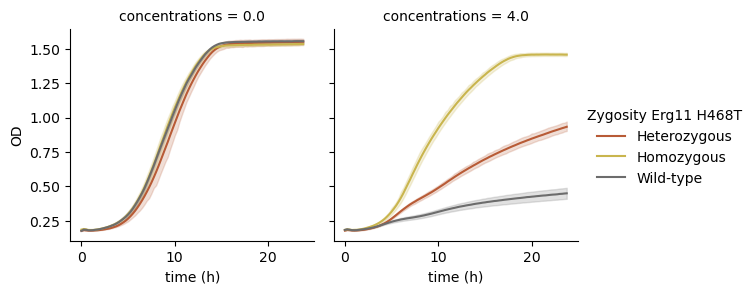

In [10]:
##Growth curves visualisation
##It can take between 30 secondes to 5 minutes to load as there is a lot of data
custom_palette = sns.blend_palette(["#B85B36","#C9B54E","#6C6C6C"], n_colors=3)

grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <= 24], col = "concentrations",  palette = custom_palette,                   
                     hue="tps" )
#to see only one add col_order=["name"] in sns.FacetGrid
grid.map(sns.lineplot, 'time (h)', 'OD')
grid.set_axis_labels('time (h)', 'OD')
grid.add_legend(title = ( 'Zygosity Erg11 H468T'))
grid.fig.subplots_adjust(top=0.9)

axes = grid.axes.flatten()


name1 = "GrowthCurves_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)
plt.savefig(f"c:{name1}.svg", format='svg', transparent=True, dpi=300, bbox_inches='tight')